In [2]:
import cv2
import numpy as np
from pdf2image import convert_from_path
import PIL
import easyocr
import os
import copy

import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont, Image

# Read the image with only words and seperate it into blocks

In [3]:
# turn pdf to jpg
path = "../../data/pdf/SheetPile/rebar_only_word.pdf"
images = convert_from_path(path, dpi =210)
cv2_img = cv2.cvtColor(np.asarray(images[0]),cv2.COLOR_RGB2BGR)
img_gray = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
_, img_th = cv2.threshold (img_gray, 240, 255, 0)
only_word_img_blur = cv2.GaussianBlur(img_th, (5, 5), 0)

cv2.imwrite("rebar_only_word.jpg", only_word_img_blur)

True

### 執行 EasyOCR

In [4]:
# setup ocr reader
reader = easyocr.Reader(['en'])
bounds = reader.readtext(only_word_img_blur, detail=1)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


#### 可以直接輸出結果

In [127]:
sheet_pile_dic = {}
import re

ocr_pile_type_dic = {"MI":"III", "I":"III", "M":"III"}

for word in bounds:
    if word[1].find("SHEET PILE") > -1:
        print(word[1])
        match1 = re.search(r'L[=-]?l(\d+)m', word[1], re.IGNORECASE)
        if match1:
            length = int(match1.group(1))+10  # 將匹配的字符串轉換為整數
        else:
            match2 = re.search(r'L[=-]?(\d+)', word[1], re.IGNORECASE)
            if match2:
                length = int(match2.group(1))
    
    match3 = re.search(r"SP-(\S+) SHEET PILE", word[1], re.IGNORECASE)
    if match3:
        if match3.group(1) in ocr_pile_type_dic:
            pile_type ="SP-" + ocr_pile_type_dic[match3.group(1)] + "-" + str(length)
        else:
            pile_type ="SP-" + match3.group(1) + "-" + str(length)
        print(f"提取的型號: {pile_type}")
        sheet_pile_dic[pile_type] = length

print(sheet_pile_dic)

SP-I SHEET PILE (L=l6m)
提取的型號: SP-III-16
SP-I SHEET PILE (L=13m)
提取的型號: SP-III-13
SP-M SHEET PILE (L=9m)
提取的型號: SP-III-9
{'SP-III-16': 16, 'SP-III-13': 13, 'SP-III-9': 9}


### 找關鍵字

In [5]:
sheetpile_location_list = []

# find sheet pile location
for w in bounds:
  if w[1].find("SHEET PILE") > -1:
    sheetpile_location_list.append(w[0]) # [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]

# sort sheet pile location by x1
sheetpile_location_list.sort(key=lambda x: x[0][0])

### 讀正式的圖檔

In [6]:
# turn pdf to jpg
path = "../../data/pdf/SheetPile/rebar_all.pdf"
images = convert_from_path(path, dpi =210)
cv2_img = cv2.cvtColor(np.asarray(images[0]),cv2.COLOR_RGB2BGR)
img_gray = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
_, img_th = cv2.threshold (img_gray, 240, 255, 0)
all_img_blur = cv2.GaussianBlur(img_th, (5, 5), 0)

### 切割演算法與呼叫

In [7]:
def block_split(list):
    img_left = 140
    img_top = 100
    img_right = 6000
    
    # split each section into blocks
    block = []
    section_img_list = []
    for i in range(len(list)):
        temp_block = [0,img_top,0,list[i][3][1]+60] # [x1, y1, x2, y2]
        # if it is the first block 求出x1
        if i == 0:
            temp_block[0] = img_left
        else:
            temp_block[0] = (list[i-1][0][0] + list[i-1][1][0] + list[i][0][0] + list[i][1][0])/4 # x1 + x2 /2
        
        # if it is the last block 求出x2
        if i == len(list)-1:
            temp_block[2] = img_right
        else:
            temp_block[2] = (list[i][0][0] + list[i][1][0] + list[i+1][0][0] + list[i+1][1][0])/4

        block.append(temp_block)
        section_img_list.append(all_img_blur[int(temp_block[1]):int(temp_block[3]), int(temp_block[0]):int(temp_block[2])])

    return block, section_img_list

sheetpile_location_block, section_img_list = block_split(sheetpile_location_list)

### 視覺化

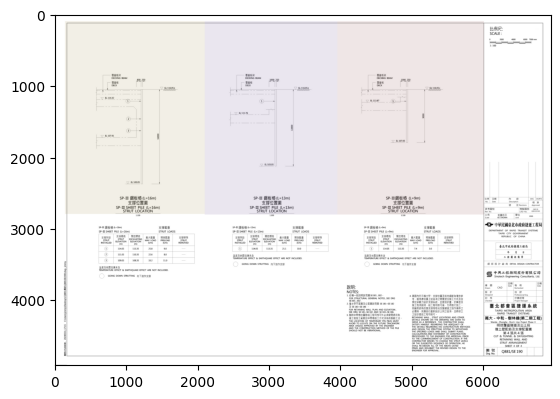

In [78]:
cv2.imwrite("rebar_all.jpg", all_img_blur)
img = cv2.imread("rebar_all.jpg")
overlay = img.copy()
output = img.copy()
for block in block_split(sheetpile_location_list):
    # plot dirrenent color for each block
    color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
    # plot the block and  color the area
    cv2.rectangle(overlay, (int(block[0]), int(block[1])), (int(block[2]), int(block[3])), color, -1)
alpha = 0.1
cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, output)
cv2.imwrite("block_split.jpg", output)
plt.imshow(output)
plt.show()

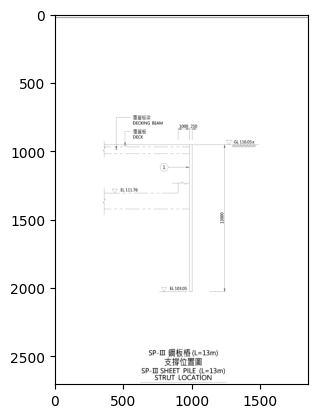

In [90]:
# plot example block img
plt.imshow(section_img_list[1], cmap='gray')
plt.show()

# 依照要求使用傳統作法或使用OpenAI

## 傳統作法

In [121]:
sheet_pile_dic = {}
import re

ocr_pile_type_dic = {"MI":"III"}

for img in section_img_list:
    # ocr
    bounds = reader.readtext(img, detail=1)
    for word in bounds:
        if word[1].find("SHEET PILE") > -1:
            match1 = re.search(r'L[=-]?l(\d+)m', word[1], re.IGNORECASE)
            if match1:
                length = int(match1.group(1))+10  # 將匹配的字符串轉換為整數
            else:
                match2 = re.search(r'L[=-]?(\d+)', word[1], re.IGNORECASE)
                if match2:
                    length = int(match2.group(1))
        
        match3 = re.search(r"SP-(\S+) SHEET PILE", word[1], re.IGNORECASE)
        if match3:
            if match3.group(1) in ocr_pile_type_dic:
                pile_type ="SP-" + ocr_pile_type_dic[match3.group(1)] + "-" + str(length)
            else:
                pile_type ="SP-" + match3.group(1) + "-" + str(length)
            print(f"提取的型號: {pile_type}")
            sheet_pile_dic[pile_type] = length

print(sheet_pile_dic)
            

提取的型號: SP-III-16
提取的型號: SP-II-13
提取的型號: SP-III-9
{'SP-III-16': 16, 'SP-II-13': 13, 'SP-III-9': 9}


In [ ]:
section_rotate_img = cv2.rotate(section_img_list[1], cv2.ROTATE_90_CLOCKWISE)
#ocr
bounds = reader.readtext(section_rotate_img, detail=1)
for word in bounds:
    print(word[1])

## OpenAI作法

In [8]:
from dotenv import load_dotenv, find_dotenv
from openai import AzureOpenAI
import os
import json

import base64
from mimetypes import guess_type

load_dotenv(find_dotenv())

api_base = os.getenv("GPT4V_ENDPOINT")
api_key= os.getenv("AZURE_OPENAI_API_KEY")
deployment_name = 'gpt4-vision'
api_version = '2023-12-01-preview'

client = AzureOpenAI(
    api_key=api_key,  
    api_version=api_version,
    base_url=f"{api_base}/openai/deployments/{deployment_name}/extensions",
)

# Function to encode a local image into data URL 
def local_image_to_data_url(image_path):
    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = 'application/octet-stream'  # Default MIME type if none is found

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"

In [9]:
response_list = []
for i in range(len(section_img_list)):
    # save image
    cv2.imwrite(f"section_{i}.jpg", section_img_list[i])
    # encode image
    image_data_url = local_image_to_data_url(f"section_{i}.jpg")
    # call api
    template = "Tell me the type of the sheet pile and the lenght of it. please response as the following template:{pile_type}-{length} e.g. SP-III-10. just return the template, do not return any other information." 
    response = client.chat.completions.create(
        model=deployment_name,
        messages=[
            { "role": "system", "content": "You are a helpful assistant." },
            { "role": "user", "content": [  
                { 
                    "type": "text", 
                    "text": template
                },
                { 
                    "type": "image_url",
                    "image_url": {
                        "url": image_data_url
                    }
                }
            ] } 
        ],
        max_tokens=500
    )
    response_list.append(response)
    # delete image
    os.remove(f"section_{i}.jpg")

In [12]:
for i in range(len(response_list)):
    print(response_list[i].choices[0].message.content)

SP-III-16m
SP-III-13m
SP-III-9m
